<a href="https://colab.research.google.com/github/raghavanmuthuraman25/CNN/blob/main/01_Cats_vs_Dogs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
kaggle_dataset = 'https://www.kaggle.com/datasets/bhavikjikadara/dog-and-cat-classification-dataset'


In [ ]:
# Colab-specific: GPU info
!nvidia-smi

# Kaggle API setup (run this in Colab cell)
from google.colab import files
files.upload()  # upload kaggle.json

!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

# Download dataset
!kaggle datasets download -d bhavikjikadara/dog-and-cat-classification-dataset
!unzip dog-and-cat-classification-dataset.zip -d ./catsdogs_data

Tue Jul 15 13:13:42 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   38C    P8              9W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

Streaming output truncated to the last 5000 lines.
  inflating: ./catsdogs_data/PetImages/Dog/5499.jpg  
  inflating: ./catsdogs_data/PetImages/Dog/55.jpg  
  inflating: ./catsdogs_data/PetImages/Dog/550.jpg  
  inflating: ./catsdogs_data/PetImages/Dog/5500.jpg  
  inflating: ./catsdogs_data/PetImages/Dog/5501.jpg  
  inflating: ./catsdogs_data/PetImages/Dog/5502.jpg  
  inflating: ./catsdogs_data/PetImages/Dog/5503.jpg  
  inflating: ./catsdogs_data/PetImages/Dog/5504.jpg  
  inflating: ./catsdogs_data/PetImages/Dog/5505.jpg  
  inflating: ./catsdogs_data/PetImages/Dog/5506.jpg  
  inflating: ./catsdogs_data/PetImages/Dog/5507.jpg  
  inflating: ./catsdogs_data/PetImages/Dog/5508.jpg  
  inflating: ./catsdogs_data/PetImages/Dog/5509.jpg  
  inflating: ./catsdogs_data/PetImages/Dog/551.jpg  
  inflating: ./catsdogs_data/PetImages/Dog/5510.jpg  
  inflating: ./catsdogs_data/PetImages/Dog/5511.jpg  
  inflating: ./catsdogs_data/PetImages/Dog/5512.jpg  
  inflating: ./catsdogs_data/PetIma

In [ ]:
!pip install tqdm

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader,random_split
from torchvision import datasets, utils, transforms
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
from torchvision.datasets import ImageFolder
import os
from tqdm import tqdm

Train size: 4000 | Val size: 1000


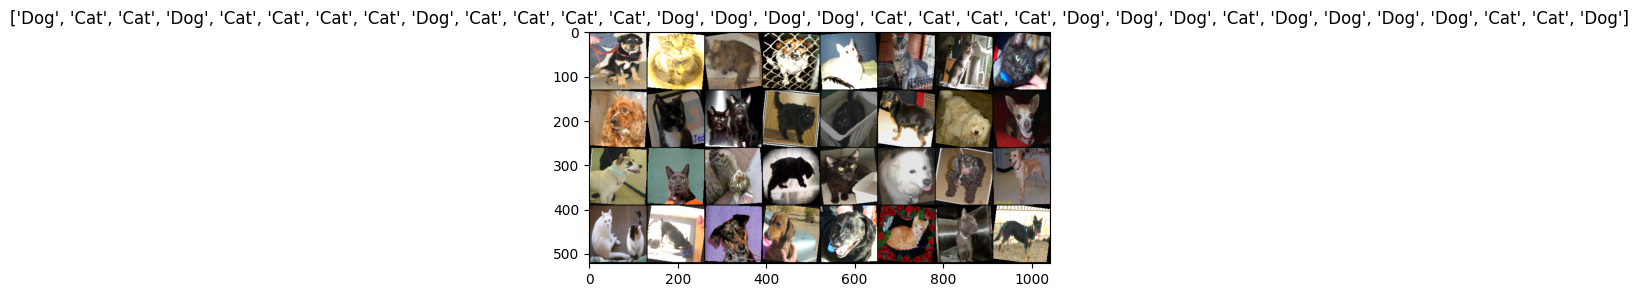

In [ ]:
# Data transforms
transform_train = transforms.Compose([
    transforms.Resize((128,128)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
])

transform = transforms.Compose([
    transforms.Resize((128,128)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.3, contrast=0.3),
    transforms.ToTensor(),
])
root_dir = '/content/catsdogs_data/PetImages'
dataset = ImageFolder(root=root_dir, transform=transform)
subset_size = 5000 +1000

# Pick random indices
indices = torch.randperm(len(dataset))[:subset_size]
subset_dataset = torch.utils.data.Subset(dataset, indices)

val_size = 1000
train_size = 4000
test_size  =1000
train_dataset, val_dataset,test_set = random_split(subset_dataset, [train_size, val_size, test_size])

# Loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_set, batch_size = 32, shuffle = False)
print(f"Train size: {len(train_dataset)} | Val size: {len(val_dataset)}")
# Preview a batch
images, labels = next(iter(train_loader))
grid = utils.make_grid(images, nrow=8, normalize=True)
plt.figure(figsize=(10,3))
plt.imshow(grid.permute(1,2,0))
plt.title([dataset.classes[i] for i in labels])
plt.axis('on')
plt.show()

In [ ]:
class SimpleCNN(nn.Module):
    def __init__(self, channels1=16, channels2=32):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, channels1, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(channels1, channels2, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(channels2 * 32 * 32, 128)
        self.fc2 = nn.Linear(128, 2)
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool(x)
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        x = self.dropout(x)
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        x=self.fc2(x)

        return x
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SimpleCNN().to(device)



In [ ]:
def train_model(model, train_loader, val_loader, lr, epochs=3):
    optimizer = optim.Adam(model.parameters(), lr=lr , weight_decay= 1e-4)
    criterion = nn.CrossEntropyLoss()

    train_losses, val_losses = [], []

    for epoch in range(epochs):
        model.train()
        epoch_loss = 0.0
        i=0
        pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}")
        for images, labels in pbar:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
            i=i+1
            pbar.set_postfix({"Batch Loss": f"{loss.item():.4f}"})


        avg_loss = epoch_loss / len(train_loader)
        train_losses.append(avg_loss)


        # Validation
        model.eval()
        val_loss = 0.0
        correct = 0
        total = 0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.cuda(), labels.cuda()
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                correct += (predicted == labels).sum().item()
                total += labels.size(0)

        val_losses.append(val_loss / len(val_loader))
        acc = correct / total
        print(f"Epoch {epoch+1}, Train Loss: {avg_loss:.4f}, Val Loss: {val_losses[-1]:.4f}, Val Acc: {acc:.4f}")

    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Val Loss')
    plt.legend()
    plt.show()


Epoch 1: 100%|██████████| 125/125 [00:16<00:00,  7.52it/s, Batch Loss=0.6889]
/usr/local/lib/python3.11/dist-packages/PIL/TiffImagePlugin.py:950: UserWarning: Truncated File Read
  warnings.warn(str(msg))


Epoch 1, Train Loss: 0.7204, Val Loss: 0.6863, Val Acc: 0.5580


Epoch 2: 100%|██████████| 125/125 [00:15<00:00,  8.25it/s, Batch Loss=0.6694]


Epoch 2, Train Loss: 0.6774, Val Loss: 0.6559, Val Acc: 0.6310


Epoch 3: 100%|██████████| 125/125 [00:15<00:00,  8.31it/s, Batch Loss=0.6849]


Epoch 3, Train Loss: 0.6490, Val Loss: 0.6132, Val Acc: 0.6910


Epoch 4: 100%|██████████| 125/125 [00:15<00:00,  7.92it/s, Batch Loss=0.5207]


Epoch 4, Train Loss: 0.6301, Val Loss: 0.6071, Val Acc: 0.6530


Epoch 5: 100%|██████████| 125/125 [00:15<00:00,  8.28it/s, Batch Loss=0.7631]


Epoch 5, Train Loss: 0.6137, Val Loss: 0.5716, Val Acc: 0.6900


Epoch 6: 100%|██████████| 125/125 [00:15<00:00,  7.95it/s, Batch Loss=0.5235]


Epoch 6, Train Loss: 0.5956, Val Loss: 0.6141, Val Acc: 0.6660


Epoch 7: 100%|██████████| 125/125 [00:15<00:00,  8.31it/s, Batch Loss=0.5712]


Epoch 7, Train Loss: 0.5882, Val Loss: 0.5814, Val Acc: 0.6990


Epoch 8: 100%|██████████| 125/125 [00:15<00:00,  7.93it/s, Batch Loss=0.6191]


Epoch 8, Train Loss: 0.5855, Val Loss: 0.5624, Val Acc: 0.7090


Epoch 9: 100%|██████████| 125/125 [00:15<00:00,  8.14it/s, Batch Loss=0.4814]


Epoch 9, Train Loss: 0.5666, Val Loss: 0.5948, Val Acc: 0.6690


Epoch 10: 100%|██████████| 125/125 [00:15<00:00,  8.21it/s, Batch Loss=0.5732]


Epoch 10, Train Loss: 0.5643, Val Loss: 0.5529, Val Acc: 0.7380


Epoch 11: 100%|██████████| 125/125 [00:15<00:00,  8.28it/s, Batch Loss=0.5406]


Epoch 11, Train Loss: 0.5552, Val Loss: 0.5798, Val Acc: 0.7030


Epoch 12: 100%|██████████| 125/125 [00:16<00:00,  7.65it/s, Batch Loss=0.5692]


Epoch 12, Train Loss: 0.5502, Val Loss: 0.5550, Val Acc: 0.7090


Epoch 13: 100%|██████████| 125/125 [00:15<00:00,  8.06it/s, Batch Loss=0.4944]


Epoch 13, Train Loss: 0.5415, Val Loss: 0.5667, Val Acc: 0.6830


Epoch 14: 100%|██████████| 125/125 [00:15<00:00,  8.32it/s, Batch Loss=0.5028]


Epoch 14, Train Loss: 0.5383, Val Loss: 0.5402, Val Acc: 0.7200


Epoch 15: 100%|██████████| 125/125 [00:15<00:00,  7.94it/s, Batch Loss=0.7123]


Epoch 15, Train Loss: 0.5383, Val Loss: 0.5622, Val Acc: 0.7250


Epoch 16: 100%|██████████| 125/125 [00:15<00:00,  8.29it/s, Batch Loss=0.5094]


Epoch 16, Train Loss: 0.5364, Val Loss: 0.5616, Val Acc: 0.7160


Epoch 17: 100%|██████████| 125/125 [00:17<00:00,  7.19it/s, Batch Loss=0.5262]


Epoch 17, Train Loss: 0.5210, Val Loss: 0.5365, Val Acc: 0.7250


Epoch 18: 100%|██████████| 125/125 [00:17<00:00,  7.05it/s, Batch Loss=0.6052]


Epoch 18, Train Loss: 0.5216, Val Loss: 0.5420, Val Acc: 0.7310


Epoch 19: 100%|██████████| 125/125 [00:15<00:00,  8.25it/s, Batch Loss=0.4000]


Epoch 19, Train Loss: 0.5256, Val Loss: 0.5368, Val Acc: 0.7170


Epoch 20: 100%|██████████| 125/125 [00:15<00:00,  8.00it/s, Batch Loss=0.6082]


Epoch 20, Train Loss: 0.5176, Val Loss: 0.5233, Val Acc: 0.7330


Epoch 21: 100%|██████████| 125/125 [00:14<00:00,  8.35it/s, Batch Loss=0.5318]


Epoch 21, Train Loss: 0.5058, Val Loss: 0.5505, Val Acc: 0.7090


Epoch 22: 100%|██████████| 125/125 [00:15<00:00,  7.98it/s, Batch Loss=0.5101]


Epoch 22, Train Loss: 0.5011, Val Loss: 0.5298, Val Acc: 0.7540


Epoch 23: 100%|██████████| 125/125 [00:15<00:00,  8.14it/s, Batch Loss=0.4553]


Epoch 23, Train Loss: 0.5174, Val Loss: 0.5356, Val Acc: 0.7290


Epoch 24: 100%|██████████| 125/125 [00:15<00:00,  8.01it/s, Batch Loss=0.6534]


Epoch 24, Train Loss: 0.5128, Val Loss: 0.5374, Val Acc: 0.7230


Epoch 25: 100%|██████████| 125/125 [00:15<00:00,  8.23it/s, Batch Loss=0.4612]


Epoch 25, Train Loss: 0.4994, Val Loss: 0.5193, Val Acc: 0.7660


Epoch 26: 100%|██████████| 125/125 [00:15<00:00,  8.26it/s, Batch Loss=0.4624]


Epoch 26, Train Loss: 0.4990, Val Loss: 0.5123, Val Acc: 0.7580


Epoch 27: 100%|██████████| 125/125 [00:15<00:00,  8.28it/s, Batch Loss=0.4094]


Epoch 27, Train Loss: 0.4894, Val Loss: 0.5423, Val Acc: 0.7350


Epoch 28: 100%|██████████| 125/125 [00:15<00:00,  8.29it/s, Batch Loss=0.5159]


Epoch 28, Train Loss: 0.4902, Val Loss: 0.5078, Val Acc: 0.7690


Epoch 29: 100%|██████████| 125/125 [00:15<00:00,  8.31it/s, Batch Loss=0.5536]


Epoch 29, Train Loss: 0.4895, Val Loss: 0.5092, Val Acc: 0.7610


Epoch 30: 100%|██████████| 125/125 [00:15<00:00,  8.32it/s, Batch Loss=0.3568]


Epoch 30, Train Loss: 0.4839, Val Loss: 0.5068, Val Acc: 0.7700


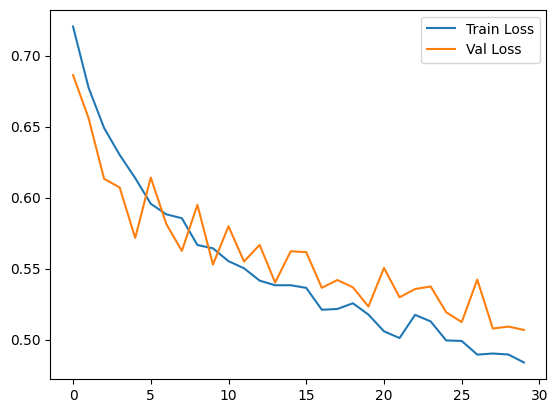

In [ ]:
train_model(model, train_loader, val_loader, lr=1e-3, epochs=30)


In [ ]:
correct = 0
total = 0

model.eval()
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

test_acc = correct / total
print(f"Test Accuracy: {test_acc*100:.2f}%")

In [ ]:
images, labels = next(iter(test_loader))
grid = utils.make_grid(images, nrow=8, normalize=True)
plt.figure(figsize=(10,3))
plt.imshow(grid.permute(1,2,0))
plt.title([dataset.classes[i] for i in labels])
plt.axis('off')
plt.show()


In [ ]:
batch_sizes = [16, 32]
learning_rates = [1e-3, 1e-4]

for bs in batch_sizes:
    for lr in learning_rates:
        print(f"=== Running bs={bs}, lr={lr} ===")
        train_loader = DataLoader(train_dataset, batch_size=bs, shuffle=True)
        val_loader = DataLoader(val_dataset, batch_size=bs, shuffle=False)

        model = SimpleCNN().cuda()
        train_model(model, train_loader, val_loader, lr)


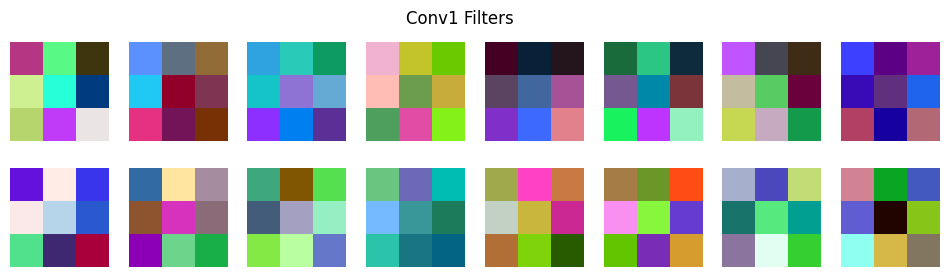

In [ ]:
# Conv1 filters
filters = model.conv1.weight.data.cpu()
fig, axes = plt.subplots(2,8, figsize=(12,3))
for i, ax in enumerate(axes.flatten()):
    if i >= filters.shape[0]:
        ax.axis('off')
        continue
    f = filters[i]
    f = (f - f.min()) / (f.max() - f.min())
    f_img = np.transpose(f.numpy(), (1,2,0))
    ax.imshow(f_img)
    ax.axis('off')
plt.suptitle("Conv1 Filters")
plt.show()


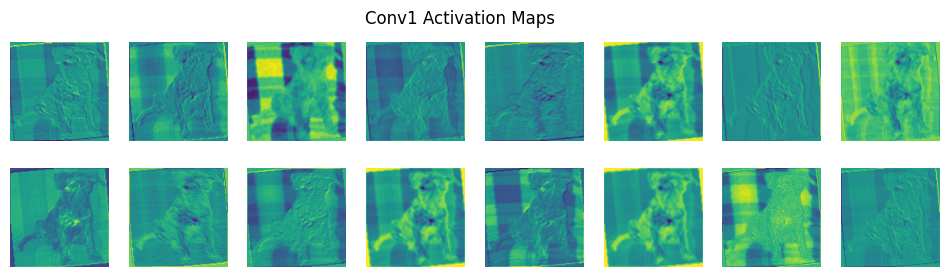

In [ ]:
# Hook activations
activation = {}
def get_activation(name):
    def hook(model, input, output):
        activation[name] = output.detach()
    return hook

model.conv1.register_forward_hook(get_activation('conv3'))

sample_image = train_dataset[1][0].unsqueeze(0).cuda()
_ = model(sample_image)

# Plot feature maps
act = activation['conv1'].cpu().squeeze()
fig, axes = plt.subplots(2,8, figsize=(12,3))
for i, ax in enumerate(axes.flatten()):
    if i >= act.shape[0]:
        ax.axis('off')
        continue
    ax.imshow(act[i].numpy(), cmap='viridis')
    ax.axis('off')
plt.suptitle("Conv1 Activation Maps")
plt.show()